<a href="https://colab.research.google.com/github/146790g/BreakHis-VGG16/blob/master/BreakHis_VGG16__Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG16モデルのファイン・チューニング法を用いた乳がん染色画像の解析
##  Deep Learning for Magnification Independent Breast Cancer Histopathology
## Image Classification

４つのMagnification levelのデータをすべて合算して、解析する

<br>

## 4 Magnification Levels: ×40, ×100, ×200, ×400


During analysis and annotation, pathologists starts by identifying ROIs in
the lowest magnification level slide (×40), then dives deeper in the latter using higher magnification levels (×100, ×200) until having a profound insight
(×400). 

<br>

## データ数 の概要

・Training Data: 5026 images <br>
  -- Benign Data: 1472 images <br>
  -- Mallignant Data: 3554 images 

・Validation Data: 2904 images <br>
  -- Benign Data: 1008 images <br>
  -- Mallignant Data:1896 images <br>

## Data Set Details by Magnification levels.

 ×40 : <br>
×100 : <br>
×200 : <br>
×400 : <br>

In [ ]:
%tensorflow_version 2.x

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data'

total 8.0K
drwx------ 4 root root 4.0K Jul 21 03:42 train
drwx------ 4 root root 4.0K Jul 27 01:49 validation


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np




#num_train = 1000              # 訓練データの画像数
#num_validation = 1000          # テストデータの画像数

img_h, img_w = 400,400
channels = 3
batch_size = 30               # ミニバッチのサイズ
train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train' # 訓練データのフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation' # テストデータのフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'        # VGG16の出力結果を保存するフォルダー
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'
    


In [ ]:
train_normal_files = os.listdir(os.path.join(train_data_dir,'benign'))
print(len(train_normal_files))
#1472
train_malignant_files = os.listdir(os.path.join(train_data_dir,'malignant'))
print(len(train_malignant_files))
#3554

validtion_normal_files = os.listdir(os.path.join(validation_data_dir,'benign'))
print(len(validtion_normal_files))
#1008
validation_malignant_files = os.listdir(os.path.join(validation_data_dir,'malignant'))
print(len(validation_malignant_files ))
#1896

1472
3554
1008
1896


### 教師用データとして、正常の画像は、1472枚、乳癌患者由来の画像は、3554枚であった。バリデーション用のデータとしては、正常の画像は、１００８枚、乳癌患者由来の画像は、１８９６枚の画像であった。


#第１章　訓練データ、テストデータの画像の視察的チェック
それぞれ、１２枚を選んできて、画像を視察的に確認する

まずは、各ディレクトリに含まれる画像のファイル名を取得する。

In [ ]:
import cv2

# !ls -lh '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train'

normal_files = os.listdir(os.path.join(train_data_dir,'benign'))[:12]
print(normal_files)

pneumonia_files = os.listdir(os.path.join(train_data_dir,'malignant'))[:12]
print(pneumonia_files)


['SOB_B_F-14-14134E-200-017.png', 'SOB_B_F-14-14134E-40-001.png', 'SOB_B_F-14-14134E-200-018.png', 'SOB_B_F-14-14134E-200-011.png', 'SOB_B_F-14-14134E-400-003.png', 'SOB_B_F-14-14134E-40-018.png', 'SOB_B_F-14-14134E-40-024.png', 'SOB_B_F-14-14134E-40-022.png', 'SOB_B_F-14-14134E-40-021.png', 'SOB_B_F-14-14134E-40-027.png', 'SOB_B_F-14-14134E-40-029.png', 'SOB_B_F-14-14134E-40-019.png']
['SOB_M_DC-14-20629-40-005.png', 'SOB_M_DC-14-20629-40-006.png', 'SOB_M_DC-14-20629-40-008.png', 'SOB_M_DC-14-20629-40-009.png', 'SOB_M_DC-14-20629-40-010.png', 'SOB_M_DC-14-20629-40-007.png', 'SOB_M_DC-14-20629-40-012.png', 'SOB_M_DC-14-20629-40-011.png', 'SOB_M_DC-14-20629-40-013.png', 'SOB_M_DC-14-20629-40-014.png', 'SOB_M_DC-14-20629-40-015.png', 'SOB_M_DC-14-20629-40-017.png']


In [ ]:
img = cv2.imread(os.path.join(train_data_dir,'benign',normal_files[3]))
#type(img)
print(img.shape[0])
print(img.shape[1])
a='('+str(img.shape[0])+','+str(img.shape[1])+')'
print(a)

460
700
(460,700)


### 正常の画像、乳癌の画像を１２枚、抽出して、視察的に確認する
### さらに、画像の画素数も調べる。

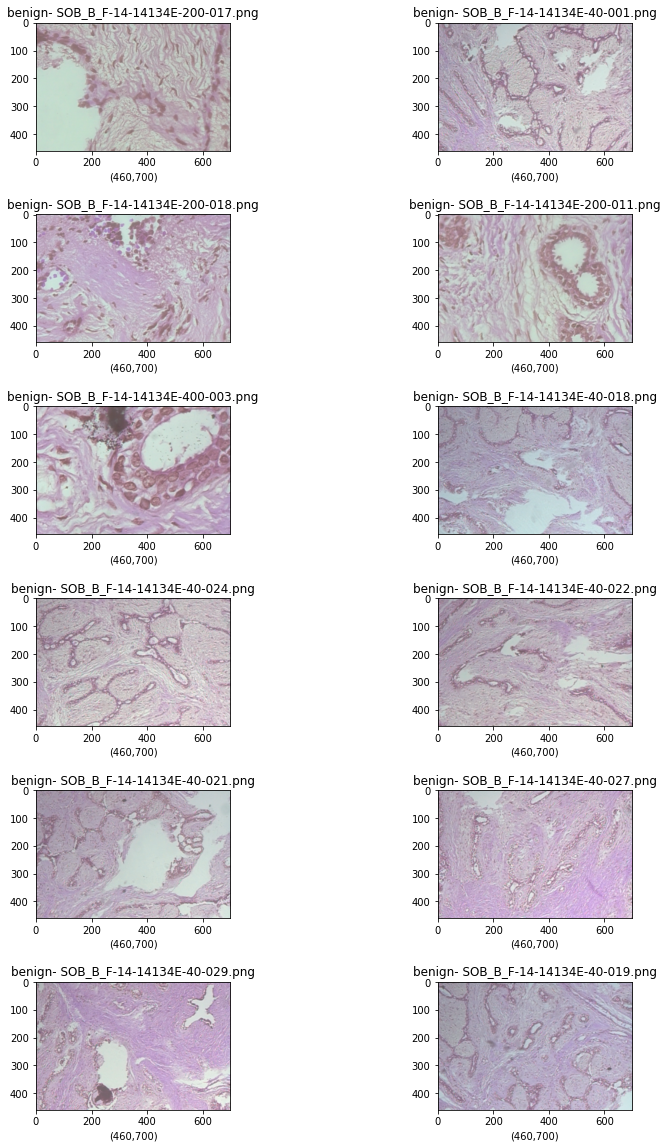

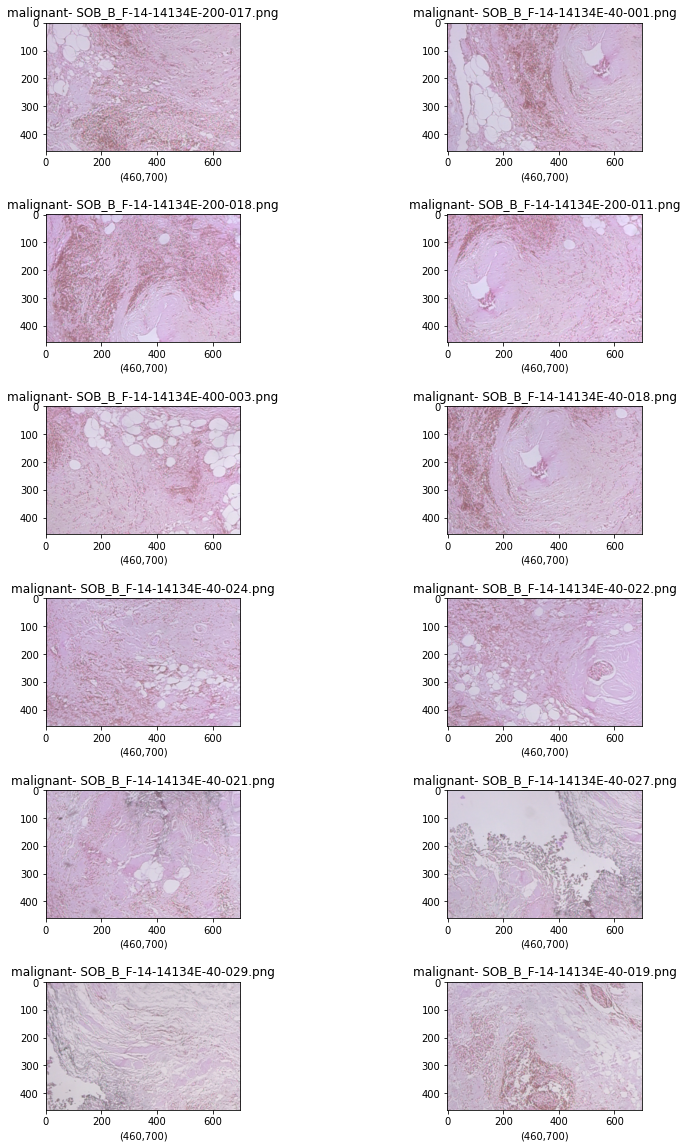

In [ ]:


import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(12):
  img = cv2.imread(os.path.join(train_data_dir,'benign',normal_files[i]))
  ax = fig.add_subplot(6,2,i+1)
  ax.set_title('benign'+'- '+normal_files[i])
  a='('+str(img.shape[0])+','+str(img.shape[1])+')'
  ax.set_xlabel(a)
  ax.imshow(img)
plt.show()

fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(12):
  img = cv2.imread(os.path.join(train_data_dir,'malignant',pneumonia_files[i]))
  ax = fig.add_subplot(6,2,i+1)
  ax.set_title('malignant'+'- '+normal_files[i])
  a='('+str(img.shape[0])+','+str(img.shape[1])+')'
  ax.set_xlabel(a)
  ax.imshow(img)
plt.show()

#第２章　訓練データ、テストデータの画像のサイズをチェック

###乳がん患者の画像から、ランダムに３００枚を抽出してきて、その画像のサイズを###DataFrameとして保存する。健康成人についても同様に、３００枚をランダムに抽出し###てきて、その画像のサイズをDataFrameとして保存する。
### 保存先：resultsディレクトリ
### データ名:malignant_image_size, normal_image_size


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
import pandas as pd
import pickleshare

%matplotlib inline

train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train'
malignant_files = os.listdir(os.path.join(train_data_dir,'malignant'))
key=np.random.choice(range(len(malignant_files)),300)
malignant_files2=[malignant_files[s] for s in key]
print(malignant_files2)


x2=[]
y2=[]

for i in range(300):
  img = cv2.imread(os.path.join(train_data_dir,'malignant', malignant_files2[i]))
  x2.append(img.shape[0])
  y2.append(img.shape[1])

malignant_image_size=pd.DataFrame([x2,y2])

result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results' 
malignant_image_size.to_pickle(os.path.join(result_dir,'malignant_image_size.pkl'))


['SOB_M_DC-14-20629-100-008.png', 'SOB_M_LC-14-15570C-200-012 (2).png', 'SOB_M_LC-14-16196-400-004.png', 'SOB_M_PC-14-19440-100-020.png', 'SOB_M_LC-14-16196-40-019.png', 'SOB_M_MC-14-13418DE-400-007.png', 'SOB_M_DC-14-2773-400-032.png', 'SOB_M_MC-14-16456-200-053.png', 'SOB_M_DC-14-17901-400-012.png', 'SOB_M_PC-14-12465-100-001.png', 'SOB_M_DC-14-12312-200-026.png', 'SOB_M_MC-14-16456-100-064.png', 'SOB_M_DC-14-16448-200-013.png', 'SOB_M_DC-14-5694-200-005.png', 'SOB_M_PC-15-190EF-100-008.png', 'SOB_M_DC-14-14946-40-028.png', 'SOB_M_PC-14-19440-400-011.png', 'SOB_M_DC-14-16188-40-011.png', 'SOB_M_LC-14-15570C-100-017.png', 'SOB_M_DC-14-15696-400-013.png', 'SOB_M_DC-14-15792-200-002.png', 'SOB_M_DC-14-5287-40-010.png', 'SOB_M_LC-14-16196-40-021.png', 'SOB_M_DC-14-10926-400-007.png', 'SOB_M_MC-14-18842-200-009.png', 'SOB_M_LC-14-15570C-40-005.png', 'SOB_M_DC-14-5695-200-005.png', 'SOB_M_DC-14-2773-40-025.png', 'SOB_M_DC-14-13993-40-034.png', 'SOB_M_DC-14-2773-100-018.png', 'SOB_M_DC-14-1

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pandas as pd
import pickleshare


%matplotlib inline

normal_files = os.listdir(os.path.join(train_data_dir,'benign'))
print(len(normal_files))
#1472


train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train'
normal_files = os.listdir(os.path.join(train_data_dir,'benign'))
key=np.random.choice(range(len(normal_files)),300)
normal_files2=[normal_files[s] for s in key]
print(normal_files2)

x=[]
y=[]

for i in range(300):
  img = cv2.imread(os.path.join(train_data_dir,'benign',normal_files[i]))
  x.append(img.shape[0])
  y.append(img.shape[1])

print(x[:10])

normal_image_size=pd.DataFrame([x,y])
normal_image_size.to_pickle(os.path.join(result_dir,'normal_image_size.pkl'))


1472
['SOB_B_TA-14-16184CD-40-022.png', 'SOB_B_TA-14-13200-40-001.png', 'SOB_B_F-14-25197-100-030.png', 'SOB_B_F-14-25197-40-039.png', 'SOB_B_F-14-21998EF-200-022.png', 'SOB_B_F-14-23060AB-100-017.png', 'SOB_B_A-14-22549AB-40-026.png', 'SOB_B_TA-14-19854C-40-011.png', 'SOB_B_F-14-23060AB-40-006.png', 'SOB_B_F-14-21998EF-100-029.png', 'SOB_B_F-14-23060CD-400-010.png', 'SOB_B_TA-14-13200-400-015.png', 'SOB_B_F-14-14134-200-013.png', 'SOB_B_F-14-29960AB-40-005.png', 'SOB_B_F-14-21998EF-400-006.png', 'SOB_B_PT-14-22704-40-016.png', 'SOB_B_PT-14-22704-200-016.png', 'SOB_B_F-14-21998EF-100-002.png', 'SOB_B_F-14-14134-100-006.png', 'SOB_B_TA-14-21978AB-400-006.png', 'SOB_B_F-14-14134-400-022.png', 'SOB_B_F-14-23060AB-40-008.png', 'SOB_B_F-14-23060AB-400-012.png', 'SOB_B_TA-14-19854C-40-002.png', 'SOB_B_TA-14-21978AB-200-010.png', 'SOB_B_TA-14-21978AB-400-013.png', 'SOB_B_PT-14-22704-40-013.png', 'SOB_B_TA-14-16184CD-200-018.png', 'SOB_B_F-14-23060CD-200-001.png', 'SOB_B_F-14-23060AB-100-001.p

### validationデータの中から、ランダムに、２０個の画像を抽出して、testフォルダ移動する。このtestデータは、モデル構築後のモデル診断に利用する。

benignの画像をvalidationのディレクトリから、testのディレクトリにコピーして、移動する

In [ ]:
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation'
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'

import os
import numpy as np
import shutil

files_normal=os.listdir(os.path.join(validation_data_dir,'benign'))

files_normal1=[f for f in files_normal if f.endswith(r".png")]

key=np.random.choice(range(len(files_normal1)),20)
files_normal2=[files_normal1[s] for s in key]

print(files_normal2)

# test
for p in files_normal2:
    shutil.copy(os.path.join(validation_data_dir, 'benign',p), os.path.join(test_dir,'benign'))



['SOB_B_TA-14-15275-200-011.png', 'SOB_B_PT-14-21998AB-40-022.png', 'SOB_B_PT-14-21998AB-100-044.png', 'SOB_B_A-14-22549G-40-033.png', 'SOB_B_A-14-22549G-200-009.png', 'SOB_B_TA-14-3411F-400-001.png', 'SOB_B_PT-14-21998AB-100-062.png', 'SOB_B_PT-14-21998AB-200-052.png', 'SOB_B_F-14-9133-200-012.png', 'SOB_B_F-14-23222AB-100-015.png', 'SOB_B_F-14-9133-400-005.png', 'SOB_B_PT-14-21998AB-200-044.png', 'SOB_B_A-14-22549G-200-009.png', 'SOB_B_TA-14-16184-100-016.png', 'SOB_B_A-14-29960CD-200-004.png', 'SOB_B_TA-14-16184-200-020.png', 'SOB_B_TA-14-16184-100-015.png', 'SOB_B_F-14-9133-200-013.png', 'SOB_B_PT-14-21998AB-400-007.png', 'SOB_B_PT-14-21998AB-100-029.png']


malignantの画像をvalidationのディレクトリから、testのディレクトリにコピーして、移動する

In [ ]:

validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation'
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'

import os
import numpy as np
import shutil

files_malignant=os.listdir(os.path.join(validation_data_dir,'malignant'))

files_malignant1=[f for f in files_malignant if f.endswith(r".png")]

key=np.random.choice(range(len(files_malignant1)),20)
files_malignant2=[files_malignant1[s] for s in key]

print(files_malignant2)

# test
for p in files_malignant2:
    shutil.copy(os.path.join(validation_data_dir, 'malignant',p), os.path.join(test_dir,'malignant'))


['SOB_M_LC-14-15570-400-026.png', 'SOB_M_DC-14-18650-40-003.png', 'SOB_M_DC-14-11951-100-004.png', 'SOB_M_LC-14-15570-100-038.png', 'SOB_M_DC-14-20636-100-026.png', 'SOB_M_DC-14-16716-40-021.png', 'SOB_M_DC-14-17614-400-010.png', 'SOB_M_DC-14-6241-200-016.png', 'SOB_M_PC-14-15687B-200-004.png', 'SOB_M_DC-14-6241-40-024.png', 'SOB_M_DC-14-2980-200-004.png', 'SOB_M_PC-14-15704-40-011.png', 'SOB_M_MC-14-18842D-40-003.png', 'SOB_M_PC-14-15704-400-025.png', 'SOB_M_DC-14-16716-200-004.png', 'SOB_M_LC-14-13412-200-002.png', 'SOB_M_LC-14-15570-200-022.png', 'SOB_M_MC-14-13413-200-022.png', 'SOB_M_MC-14-13413-200-010.png', 'SOB_M_DC-14-18650-400-008.png']


健康成人の画像から、ランダムに３００枚を抽出してきて、その画像のサイズを
プロットする。

456
460
700
700


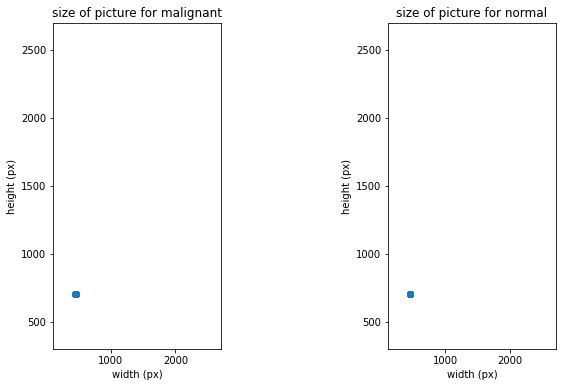

In [ ]:
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results' 
df_malignant = pd.read_pickle(os.path.join(result_dir,'malignant_image_size.pkl'))
df_normal = pd.read_pickle(os.path.join(result_dir,'normal_image_size.pkl'))

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(9,6))
plt.subplots_adjust(wspace=1)
ax1=fig.add_subplot(1,2,1)

min1=min(df_malignant.iloc[0,].append(df_normal.iloc[0,]))
max1=max(df_malignant.iloc[0,].append(df_normal.iloc[0,]))
print(min1)
print(max1)

min2=min(df_malignant.iloc[1,].append(df_normal.iloc[1,]))
max2=max(df_malignant.iloc[1,].append(df_normal.iloc[1,]))
print(min2)
print(max2)

ax1.set_title('size of picture for malignant')
ax1.set_xlabel('width (px)')
ax1.set_ylabel('height (px)')
ax1.set_xlim(120,2700)
ax1.set_ylim(300,2700)
ax1.scatter(df_malignant.iloc[0,],df_malignant.iloc[1,])

ax2=fig.add_subplot(1,2,2)

ax2.set_title('size of picture for normal')
ax2.set_xlabel('width (px)')
ax2.set_ylabel('height (px)')
ax2.set_xlim(120,2700)
ax2.set_ylim(300,2700)
ax2.scatter(df_normal.iloc[0,],df_normal.iloc[1,])

plt.show()

In [ ]:
normal_min_x=min(df_normal.iloc[0,])
normal_max_x=max(df_normal.iloc[0,])
malignant_min_x=min(df_malignant.iloc[0,])
malignant_max_x=max(df_malignant.iloc[0,])
print(normal_min_x)
print(normal_max_x)
print(malignant_min_x)
print(malignant_max_x)

min2=min(df_normal.iloc[1,])
max2=max(df_malignant.iloc[1,])

normal_min_y=min(df_normal.iloc[1,])
normal_max_y=max(df_normal.iloc[1,])
malignant_min_y=min(df_malignant.iloc[1,])
malignant_max_y=max(df_malignant.iloc[1,])
print(normal_min_y)
print(normal_max_y)
print(malignant_min_y)
print(malignant_max_y)

460
460
456
460
700
700
700
700


### 【考察】
乳がん患者の染色画像と、健康成人の染色画像のサイズは、ほぼ同程度であった。
健康成人の画像は、横のサイズは、いずれも460pxであった。縦のサイズは、いずれも700pxであった。

乳癌患者の画像は、横のサイズは、456から460pxの間であった。縦のサイズは、いずれも700 pxであった。

健康成人の画像と乳がん患者の画像が、同程度の画素数のため、モデル構築には有用であることが確認された。
